In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
import re
data = pd.read_csv('techscene.csv')

# Data cleaning

## Normalizing job titles

In order to make cleaning and analysis easier, we replace all uppercase letters in the data with lowercase. We also remove some instances of superfluous information from job titles, such as strings like "(m/f/d)" or "SEB | Tallinn".

In [2]:
for column in data.columns:#teeme kõik väiketähtedeks
  data[column]=data[column].str.lower()
#job_name
#remove (m/f/d),(m/f/x),| SEB, Tallinn,
data['job_name']=data['job_name'].str.replace('(m/f/d)', '').replace('(m/f/x)','').replace('| SEB, Tallinn','').replace('\"','')

Some of the data from the beginning of the scraping period doesn't include the field `domain`; the value of this field for these listings is `nan`. We can retroactively add these based on the title of the listing.

In [76]:
data[data['domain'].isna()]

,company_name,job_name,job_link,date_added,domain
57,nexd,javascript developer (mid/senior level),https://www.nexd.com/career/javascript-develop...,2024-03-26 00:00:00,NaN
60,relax gaming,junior developer,https://relaxgaming.bamboohr.com/careers/300,2024-03-26 00:00:00,NaN
62,interactive brokers,qt developer,https://boards.greenhouse.io/ibkr/jobs/6727389002,2024-03-26 00:00:00,NaN
63,dynatrace,senior code module (java) engineer: discover t...,https://jobs.smartrecruiters.com/dynatrace1/74...,2024-03-26 00:00:00,NaN
64,dynatrace,senior code module (c++) engineer for our pyth...,https://jobs.smartrecruiters.com/dynatrace1/74...,2024-03-26 00:00:00,NaN
...,...,...,...,...,...
737,luminor,senior compliance officer (assurance unit),https://luminorbank.teamtailor.com/jobs/354120...,2024-04-02 00:00:00,NaN
738,cybernetica,post-quantum cryptography engineer,https://cyber.teamdash.com/p/job/iqn79wzx/post...,2024-04-02 00:00:00,NaN
739,cybernetica,researcher,https://cyber.teamdash.com/p/job/pagseczx/rese...,2024-04-02 00:00:00,NaN
740,cybernetica,data architect,https://cyber.teamdash.com/p/job/knvredgr/data...,2024-04-02 00:00:00,NaN


In [53]:
data['domain'].unique()

array([nan, 'analytics', 'front-end', 'back-end', 'full-stack', 'mobile',
       'software-development', 'other', 'devops-sre', 'data-science',
       'cyber-security', 'ai-ml', 'qa', 'sales', 'finance', 'marketing',
       'design', 'hr', 'customer-support', 'management'], dtype=object)

In [3]:
replacement_dict={#regex: domain,
  'software engineer|tarkvaraarendaja|systems engineer|test automation engineer|scala engineer|platform engineer|software support engineer': 'software-development',
  'front-end|frontend|react': 'front-end',
  'back-end|backend': 'back-end',
  'android|ios': 'mobile',
  'devops': 'devops-sre',
  'data scientist|data engineer': 'data-science',
  'full-stack|full stack': 'full-stack',
  'qa engineer|quality engineer':'qa',
  'analyst|monitooringu spetsialist':'analytics',
  'people operations':'hr',
  'content developer|branding|brand manager':'marketing',
  'product owner|compliance officer|projektijuht|team lead|project lead':'management',
  'manager, debt capital markets|business analyst|business intelligence|aml|financial|risk|kindlustus|ärianalüüs|finance developer': 'finance',
  'cyber security|cryptography engineer|soc analyst|küberturvalisus|secops|protection|surveillance': 'cyber-security',
  'ai engineer|machine learning': 'ai-ml',
  'client specialist|sales manager|account manager|account management': 'sales',
  'support engineer|support associate|tugiteenus|helpdesk': 'customer-support'
  }
for index, row in data[data['domain'].isna()].iterrows():#iterate through all listings that have the 'domain' column as 'nan'
  matched=False
  for regex in replacement_dict.keys():
    if not matched and re.search(regex,row['job_name']):#check if any of the regexes in the dictionary match the name of the listing, if they do, add a domain from replacement_dict
      matched=True
      data.loc[index,'domain']=replacement_dict[regex]
      print(row['job_name']+': changed domain to '+replacement_dict[regex])#debugging
  if not matched:#debugging
    print(row['job_name']+' not matched')

front-end software engineer: changed domain to software-development
react native developer: changed domain to front-end
front-end developer: changed domain to front-end
front-end-vanemarendaja: changed domain to front-end
front-end developer: changed domain to front-end
senior react native engineer: changed domain to front-end
full-stack developer (php, vue.js): changed domain to full-stack
front-end developer for internetbank platform team | seb, tallinn: changed domain to front-end
lead full-stack react developer: changed domain to front-end
react front-end developer (mid/senior): changed domain to front-end
react native developer: changed domain to front-end
senior frontend developer: changed domain to front-end
front-end developer for hub88: changed domain to front-end
gaming - frontend software engineer: changed domain to software-development
senior backend developer (.net): changed domain to back-end
gaming - backend .net software engineer: changed domain to software-development


In [4]:
data[data['domain'].isna()]

,company_name,job_name,job_link,date_added,domain
57,nexd,javascript developer (mid/senior level),https://www.nexd.com/career/javascript-develop...,2024-03-26 00:00:00,NaN
60,relax gaming,junior developer,https://relaxgaming.bamboohr.com/careers/300,2024-03-26 00:00:00,NaN
62,interactive brokers,qt developer,https://boards.greenhouse.io/ibkr/jobs/6727389002,2024-03-26 00:00:00,NaN
63,dynatrace,senior code module (java) engineer: discover t...,https://jobs.smartrecruiters.com/dynatrace1/74...,2024-03-26 00:00:00,NaN
64,dynatrace,senior code module (c++) engineer for our pyth...,https://jobs.smartrecruiters.com/dynatrace1/74...,2024-03-26 00:00:00,NaN
...,...,...,...,...,...
734,luminor,summer internship in banking back-office,https://luminorbank.teamtailor.com/jobs/368912...,2024-04-02 00:00:00,NaN
735,luminor,internal auditor,https://luminorbank.teamtailor.com/jobs/372078...,2024-04-02 00:00:00,NaN
736,luminor,it auditor,https://luminorbank.teamtailor.com/jobs/372038...,2024-04-02 00:00:00,NaN
739,cybernetica,researcher,https://cyber.teamdash.com/p/job/pagseczx/rese...,2024-04-02 00:00:00,NaN


## Compressing consecutive listings

Currently, our data contains every instance of a listing scraped in a day. For purposes of analysis, it might be helpful to compress the data so that consecutive appearances of one listing get turned into one single entry, with new fields `first_appeared` and `last_appeared`.

In [ ]:
"""
Groups data by company name, job name, and job link. 
Sorts the data by date added and creates blocks of consecutive job postings.
"""
#might not work
def get_consecutive_blocks(data):

    data['date_added'] = pd.to_datetime(data['date_added']).dt.date

    # Normalize text for comparison
    data['job_name'] = data['job_name'].str.lower()
    data['company_name'] = data['company_name'].str.lower()

    # Remove exact duplicates
    data = data.drop_duplicates()

    # Create an empty DataFrame with specified columns
    new_data = pd.DataFrame(columns=["company_name", "job_name", "domain", "first_appeared", "last_appeared", "job_link"])

    grouped = data.groupby(["company_name", "job_name", "job_link"])
    
    for (company_name, job_name, job_link), group in grouped:
        group = group.sort_values('date_added')

        start_date = None
        prev_date = None

        # Get domain if exists in the group
        domain = group['domain'].dropna().iloc[0] if not group['domain'].dropna().empty else None

        for current_date in group['date_added']:
            if start_date is None:
                start_date = current_date
                prev_date = current_date
            elif (current_date - prev_date).days > 1:
                # Special case: check only for 2024-09-06
                if (prev_date == pd.to_datetime('2024-09-05').date() and 
                    current_date == pd.to_datetime('2024-09-07').date()):
                    prev_date = current_date  # Assume continuity
                else:
                    # Save current block if gap is not special case
                    new_data = pd.concat([new_data, pd.DataFrame({
                        "company_name": [company_name],
                        "job_name": [job_name],
                        "domain": [domain],
                        "first_appeared": [start_date],
                        "last_appeared": [prev_date],
                        "job_link": [job_link]
                    })], ignore_index=True)
                    start_date = current_date

                start_date = current_date  # Start a new block

            prev_date = current_date

        # Save the last block
        new_data = pd.concat([new_data, pd.DataFrame({
            "company_name": [company_name],
            "job_name": [job_name],
            "domain": [domain],
            "first_appeared": [start_date],
            "last_appeared": [prev_date],
            "job_link": [job_link]
        })], ignore_index=True)

    return new_data

# Example usage:
# data = pd.read_csv('input.csv')
nd = data.copy()
processed_data = get_consecutive_blocks(data)
#processed_data.to_csv('new_data3442!!!.csv', index=False)


In [96]:
"""
Groups data by company name, job name, and job link.
Finds the first appearance and last appearance dates.
"""

def process_job_data(data):
    data['date_added'] = pd.to_datetime(data['date_added']).dt.date

    # Create an empty DataFrame with specified columns
    new_data = pd.DataFrame(columns=["company_name", "job_name", "domain", "first_appeared", "last_appeared", "job_link"])
    
    # Group by unique identifying columns
    grouped = data.groupby(["company_name", "job_name", "job_link"])
    
    # Iterate through each unique group
    for (company_name, job_name, job_link), group in grouped:
        # Find the first and last appearance dates
        first_appeared = group['date_added'].min()
        last_appeared = group['date_added'].max()
        

        # Get domain if exists in the group
        domain = group['domain'].dropna().iloc[0] if not group['domain'].dropna().empty else None

        # Create a new row for this unique entry
        new_row = pd.DataFrame({
            "company_name": [company_name],
            "job_name": [job_name],
            "domain": [domain],
            "first_appeared": [first_appeared],
            "last_appeared": [last_appeared],
            "job_link": [job_link]
        })
        
        # Append to new_data
        new_data = pd.concat([new_data, new_row], ignore_index=True)
    
    return new_data

# Example usage
# data = pd.read_csv('your_input_file.csv')  # Load your input data
nd = data.copy()
new_data = process_job_data(data)
#new_data.to_csv('new_data3442!!!.csv', index=False)  # Save processed data

In [99]:
"""
Checks if first data has the same links as second data.
"""
def check_links(data, data2):

    links1 = data["job_link"].unique()
    links2 = data2["job_link"].unique()
    for link in links1:
        if link not in links2:
            print(link)

In [106]:

for index, row in new_data[new_data['domain'].isna()].iterrows():#iterate through all listings that have the 'domain' column as 'nan'
  matched=False
  for regex in replacement_dict.keys():
    if not matched and re.search(regex,row['job_name']):#check if any of the regexes in the dictionary match the name of the listing, if they do, add a domain from replacement_dict
      matched=True
      new_data.loc[index,'domain']=replacement_dict[regex]
      print(row['job_name']+': changed domain to '+replacement_dict[regex])#debugging
  if not matched:#debugging
    print(row['job_name']+' not matched')

irb model validation specialist not matched
commerce compliance officer not matched
director of product marketing, eu not matched
core system (tuum) product owner: changed domain to management
technical support engineer not matched
compliance officer (aml/cft/cfp & sanctions investigations unit) not matched
operational risk manager (third party and outsourcing risk) not matched
senior it service manager not matched
senior brand manager not matched
finance developer (treasury area) in business reporting solutions team | seb, tallinn not matched
it reporting engineer in finance & risk tribe | seb, tallinn not matched
product marketing manager - tallinn (m/f/x) not matched
test engineer (m/f/x) not matched
actuary in p&c insurance not matched
internal auditor not matched
solution architect for servicenow platform not matched
staff site reliability engineer (sre) not matched
verification area lead not matched
lead product designer not matched
workplace coordinator not matched


In [6]:
new_data[new_data["domain"].isna()]

,company_name,job_name,domain,first_appeared,last_appeared,job_link
70,bigbank,cross-border service specialist,None,2024-03-26,2024-03-26,https://jobs.bigbank.eu/cross-border-service-s...
71,bigbank,irb model validation specialist,None,2024-03-26,2024-03-26,https://jobs.bigbank.eu/irb-model-validation-s...
788,katana,"director of product marketing, eu",None,2024-03-26,2024-03-26,https://careers.katanamrp.com/jobs/3669087-dir...
1054,luminor,senior it service manager,None,2024-03-26,2024-03-26,https://luminorbank.teamtailor.com/jobs/372229...
1432,skeleton technologies,product marketing manager - tallinn (m/f/x),None,2024-03-26,2024-03-26,https://apply.workable.com/j/50ef428f64
1433,skeleton technologies,test engineer (m/f/x),None,2024-03-26,2024-03-26,https://apply.workable.com/j/7ce6d60c81
1506,swedbank,actuary in p&c insurance,None,2024-03-26,2024-03-26,https://jobs.swedbank.com/jobs/18208-actuary-i...
1525,swedbank,internal auditor,None,2024-03-26,2024-03-26,https://jobs.swedbank.com/jobs/18247-internal-...
1543,swedbank,solution architect for servicenow platform,None,2024-03-26,2024-03-26,https://jobs.swedbank.com/jobs/16988-solution-...
1640,veriff,staff site reliability engineer (sre),None,2024-03-26,2024-03-26,https://www.veriff.com/careers/position/704440...


In [116]:
levels_df = new_data.copy()

level_replacement_dict={#regex: domain,
  r'senior|vanem arendaja': 'senior',
  r'intern': 'intern',
  r'junior': 'junior',
  r'lead': 'lead',
  r'head': 'head',
  r'director': 'director'
}
levels_df['level'] = None
for index, row in levels_df[levels_df['level'].isna()].iterrows():#iterate through all listings that have the 'domain' column as 'nan'
  matched=False
  for regex in level_replacement_dict.keys():
    if not matched and re.search(regex,row['job_name']):#check if any of the regexes in the dictionary match the name of the listing, if they do, add a domain from replacement_dict
      matched=True
      levels_df.loc[index,'level']=level_replacement_dict[regex]
  #    print(row['job_name']+': changed domain to '+level_replacement_dict[regex])#debugging
  if not matched:#debugging
    levels_df.loc[index,'level']='mid/unknown'
  #  print(row['job_name']+' not matched')
#df[new_data['level'].isna()]

#df[new_data['level'].notna()]
levels_df[levels_df['level'] == 'director']

,company_name,job_name,domain,first_appeared,last_appeared,job_link,level
153,bolt,"director of product, commerce",management,2024-06-25,2024-09-19,https://careers.bolt.eu/positions/7441591002,director
271,bolt,"regional director, bolt food",management,2024-09-20,2024-11-10,https://careers.bolt.eu/positions/7607177002,director
562,coolbet,director of sports,management,2024-05-17,2024-06-03,https://careers.coolbet.ee/jobs/4500416-direct...,director
563,coolbet,"director, accounting",finance,2024-11-04,2024-11-10,https://careers.coolbet.ee/jobs/5153313-direct...,director
694,foxway,sales director,sales,2024-04-11,2024-07-11,https://jobs.foxway.com/jobs/3819271-sales-dir...,director
788,katana,"director of product marketing, eu",None,2024-03-26,2024-03-26,https://careers.katanamrp.com/jobs/3669087-dir...,director
1424,skeleton technologies,director of communications (m/f/x),management,2024-11-01,2024-11-10,https://apply.workable.com/j/229b859ef7,director
1485,starship,customer success director,management,2024-08-21,2024-09-08,https://starship.teamtailor.com/jobs/4831478-c...,director
1610,veriff,director of engineering,management,2024-04-27,2024-06-06,https://www.veriff.com/careers/position/733016...,director
1611,veriff,director of engineering,management,2024-08-13,2024-11-06,https://www.veriff.com/careers/position/759396...,director


# Analyzing listings by time

## Patterns of posting new listings


## Identify listings that have been up for a long time
Sort by length, report results, are there any other common traits between these listings?


In [34]:
df = new_data.copy()

df["length"] = df['last_appeared'] - df['first_appeared'] + pd.Timedelta(days=1)

df.sort_values("length", inplace=True, ascending=False)

df

,company_name,job_name,domain,first_appeared,last_appeared,job_link,length
180,bolt,group product manager,management,2024-03-26,2024-11-10,https://careers.bolt.eu/positions/6785489002,230 days 00:00:00
390,bolt,senior product manager,management,2024-03-26,2024-11-10,https://careers.bolt.eu/positions/6604607002,230 days 00:00:00
337,bolt,"senior data engineer, data platform - ingestion",data-science,2024-03-26,2024-11-10,https://careers.bolt.eu/positions/6846009002,230 days 00:00:00
345,bolt,"senior data scientist, investment modeling",data-science,2024-03-26,2024-11-10,https://careers.bolt.eu/positions/7096663002,230 days 00:00:00
41,betsson group,engagement - backend software engineer,software-development,2024-03-26,2024-11-10,https://www.betssongroup.com/job/engagement-ba...,230 days 00:00:00
...,...,...,...,...,...,...,...
482,bolt,"staff product designer, rides",design,2024-10-21,2024-10-21,https://careers.bolt.eu/positions/7692217002,1 days 00:00:00
1726,wise,fraud agent,other,2024-05-24,2024-05-24,https://jobs.smartrecruiters.com/wise/74399998...,1 days 00:00:00
1873,wise,senior seo manager,marketing,2024-08-15,2024-08-15,https://jobs.smartrecruiters.com/wise/74400000...,1 days 00:00:00
1233,playtech,cross product technical project manager,management,2024-05-07,2024-05-07,https://jobs.smartrecruiters.com/playtech/7439...,1 days 00:00:00


### What is the most popular weekday for posting new listings?

In [7]:
#weekdays_mod7=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
# #for leap years, doomsday is on January 4th, February 29th etc.
#doomsdays_bymonth=[4,29,14,4,9,6,11,8,5,10,7,12]
#def determine_weekday(s):
#  #use the Doomsday algorithm for determining the day of the week based on date. see https://en.wikipedia.org/wiki/Doomsday_rule
#  month=int(s[5:7])
#  day=int(s[8:10])
#  doomsday=doomsdays_bymonth[month-1]
#  #anchor day for 2024 is Thursday, which corresponds to 4
#  mod=(4 + (day - doomsday) + 35) % 7 
#  return weekdays_mod7[mod]

#apply the function on every listing to get the weekday
#data['weekday_added']=data['date_added'].apply(lambda x: determine_weekday(x))
data['date_added'] = pd.to_datetime(data['date_added'])
data['weekday_added']=data['date_added'].dt.day_name()
  

In [29]:
data

,company_name,job_name,job_link,date_added,domain,weekday_added
0,spectrocoin,front-end software engineer,https://careers.spectrocoin.com/position.html?...,2024-03-26,software-development,Tuesday
1,spectrocoin,react native developer,https://careers.spectrocoin.com/position.html?...,2024-03-26,front-end,Tuesday
2,novater solutions,front-end developer,https://novater.com/careers/front-end-developer/,2024-03-26,front-end,Tuesday
3,lhv,front-end-vanemarendaja,https://boards.greenhouse.io/lhv/jobs/7257214002,2024-03-26,front-end,Tuesday
4,qminder,front-end developer,https://apply.workable.com/j/3a16ed0568,2024-03-26,front-end,Tuesday
...,...,...,...,...,...,...
85698,luminor,data oversight risk officer,https://luminorbank.teamtailor.com/jobs/515065...,2024-11-10,other,Sunday
85699,luminor,senior anti-fraud compliance officer,https://luminorbank.teamtailor.com/jobs/515777...,2024-11-10,other,Sunday
85700,luminor,kõnekeskuse kliendinõustaja,https://luminorbank.teamtailor.com/jobs/475659...,2024-11-10,other,Sunday
85701,evitec,open application,https://careers.evitec.com/jobs/1367354-open-a...,2024-11-10,other,Sunday


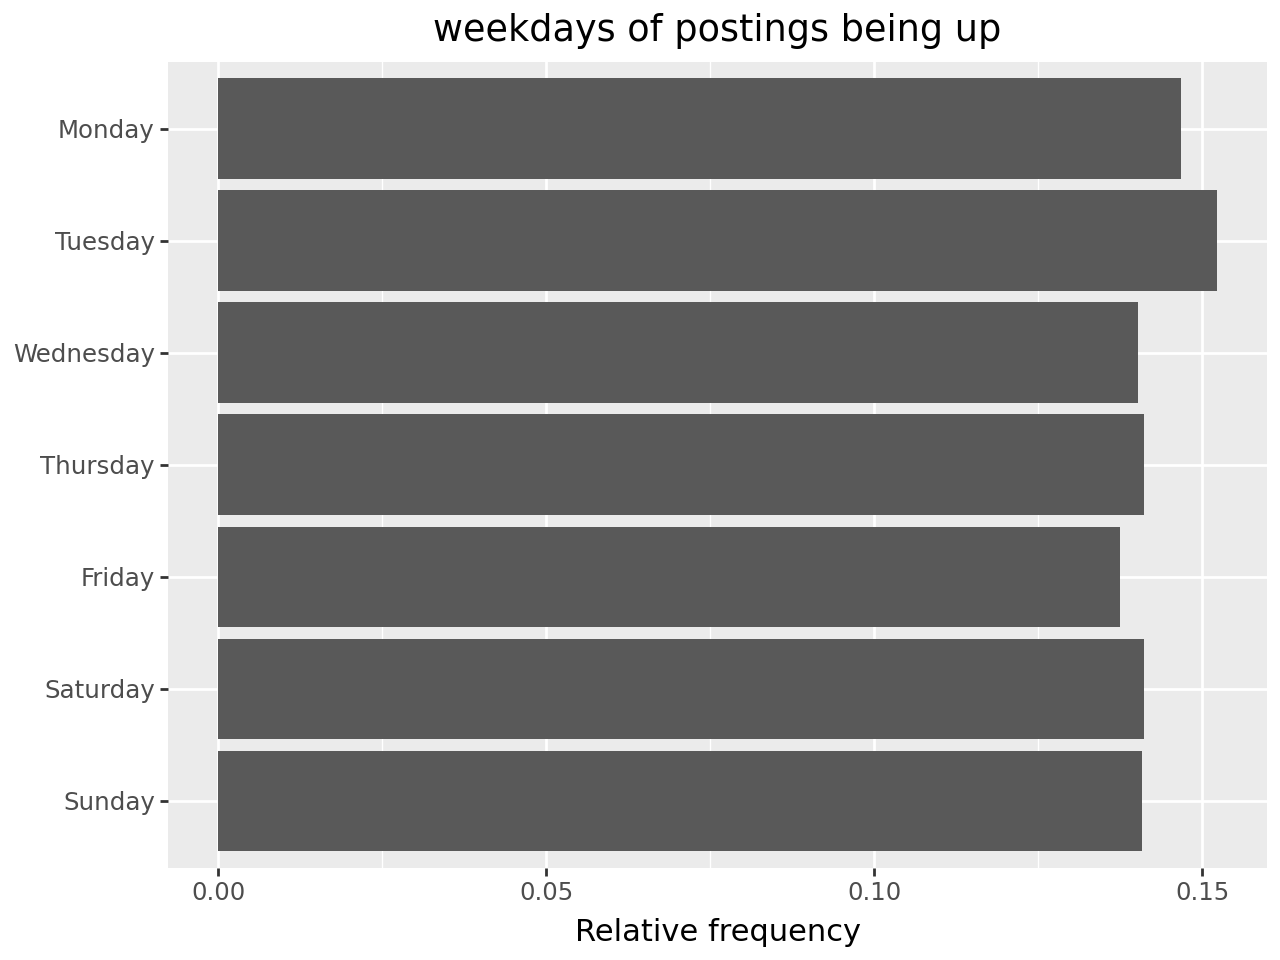

In [8]:
#weekdays_sorted=['Sun','Sat','Fri','Thu','Wed','Tue','Mon']
weekdays_sorted=['Sunday','Saturday','Friday','Thursday','Wednesday','Tuesday','Monday']
weekday_cat=pd.Categorical(data['weekday_added'], categories=weekdays_sorted)

( p9.ggplot(
    data=data,
    mapping=p9.aes(x='weekday_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("weekdays of postings being up")
)

In [19]:
new_data['first_appeared'] = pd.to_datetime(new_data['first_appeared'])
new_data['last_appeared'] = pd.to_datetime(new_data['last_appeared'])
new_data['weekday_first']=new_data['first_appeared'].dt.day_name()
new_data['weekday_last']=new_data['last_appeared'].dt.day_name()



In [20]:
new_data

,company_name,job_name,domain,first_appeared,last_appeared,job_link,weekday,weekday_first,weekday_last
0,adcash,devops intern,devops-sre,2024-03-26,2024-04-03,https://careers.adcash.com/jobs/3590778-devops...,Tuesday,Tuesday,Wednesday
1,adcash,devops intern,devops-sre,2024-06-04,2024-06-19,https://careers.adcash.com/jobs/4561598-devops...,Tuesday,Tuesday,Wednesday
2,adcash,digital marketing specialist,marketing,2024-07-04,2024-08-18,https://careers.adcash.com/jobs/4695248-digita...,Thursday,Thursday,Sunday
3,adcash,documentation specialist,other,2024-04-16,2024-05-19,https://careers.adcash.com/jobs/3877122-docume...,Tuesday,Tuesday,Sunday
4,adcash,influencer marketing manager,marketing,2024-05-17,2024-07-14,https://careers.adcash.com/jobs/4475596-influe...,Friday,Friday,Sunday
...,...,...,...,...,...,...,...,...,...
2123,yolo group,tradeart operations specialist,other,2024-05-27,2024-06-10,https://careers.yolo.com/jobs/4525692-tradeart...,Monday,Monday,Monday
2124,yolo group,turkish sportsbet operations executive,other,2024-04-15,2024-04-22,https://careers.yolo.com/jobs/3780529-turkish-...,Monday,Monday,Monday
2125,yolo group,vip crm specialist,other,2024-07-03,2024-08-05,https://careers.yolo.com/jobs/4697192-vip-crm-...,Wednesday,Wednesday,Monday
2126,yolo group,vip host (japanese/arabic/hindi/english speaking),other,2024-03-26,2024-05-09,https://careers.yolo.com/jobs/3611277-vip-host...,Tuesday,Tuesday,Thursday


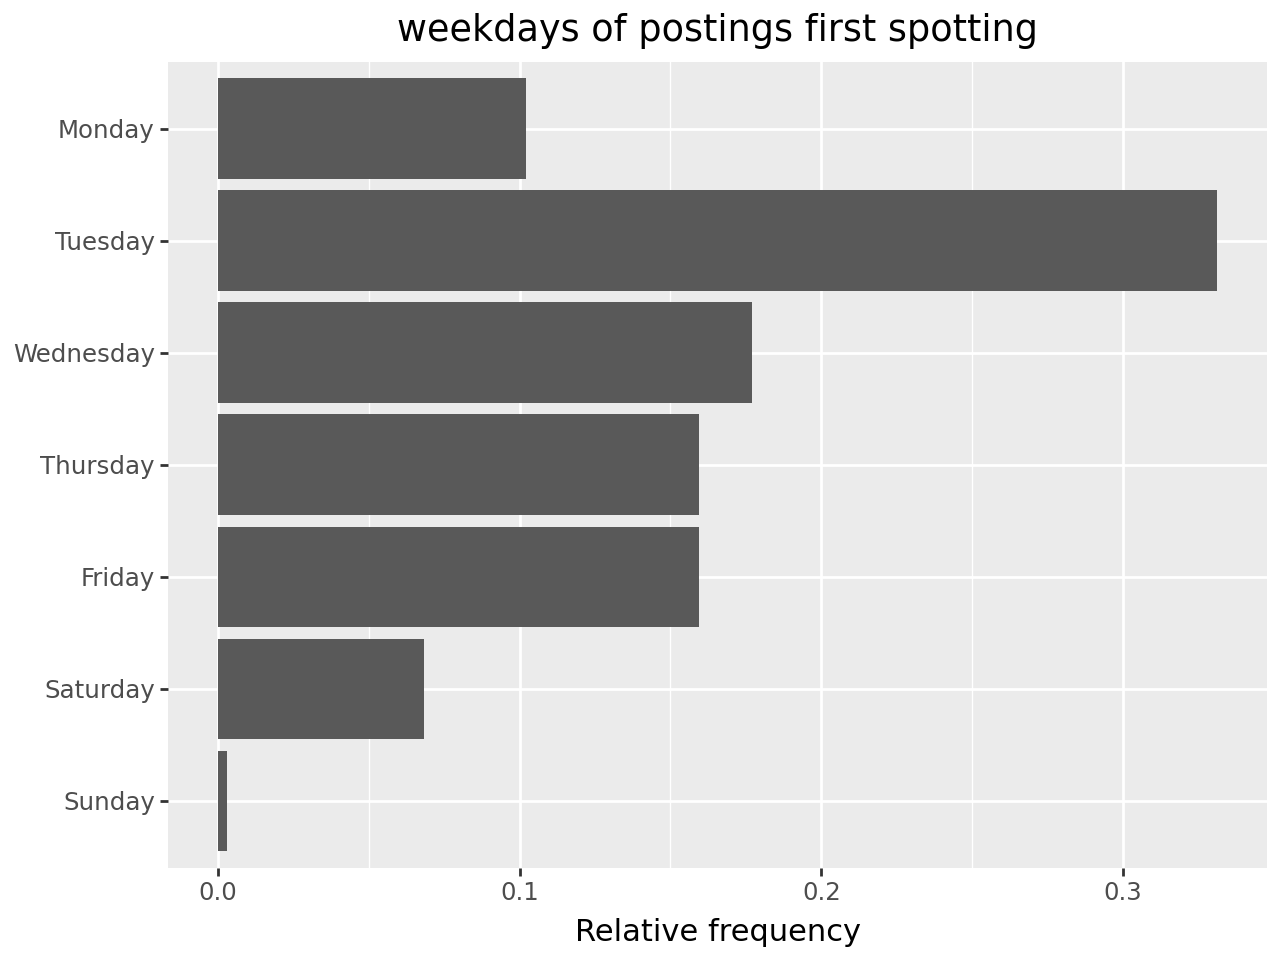

In [21]:
weekdays_sorted=['Sunday','Saturday','Friday','Thursday','Wednesday','Tuesday','Monday']
weekday_cat=pd.Categorical(new_data['weekday_first'], categories=weekdays_sorted)

( p9.ggplot(
    data=new_data,
    mapping=p9.aes(x='weekday_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("weekdays of postings first spotting")
)

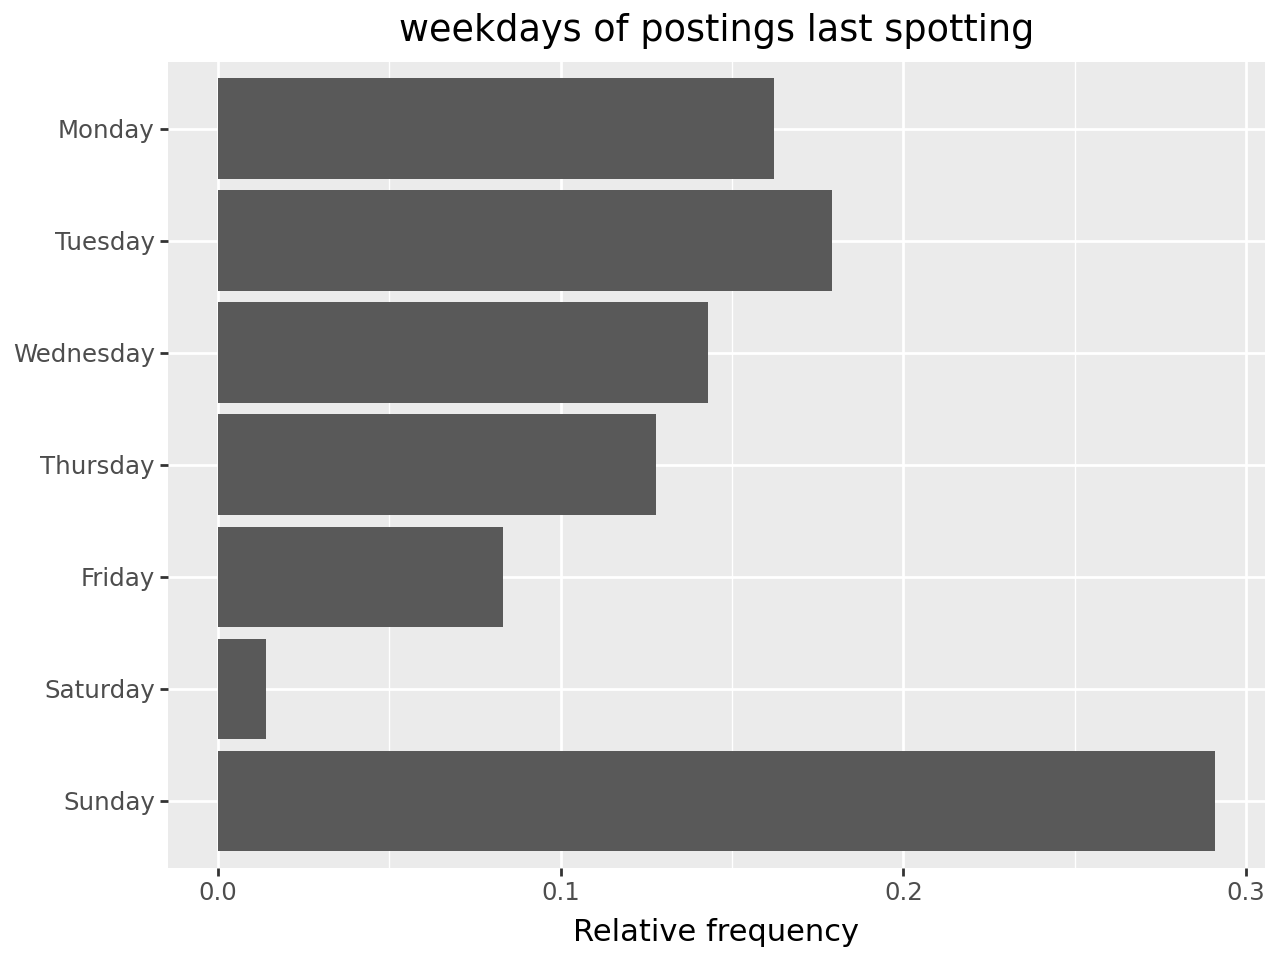

In [23]:
weekdays_sorted=['Sunday','Saturday','Friday','Thursday','Wednesday','Tuesday','Monday']
weekday_cat=pd.Categorical(new_data['weekday_last'], categories=weekdays_sorted)

( p9.ggplot(
    data=new_data,
    mapping=p9.aes(x='weekday_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("weekdays of postings last spotting")
)

## Identify listings that get posted repeatedly
Kasutame decision treed, et ennustada kuulutuse kordumist

# What domains are the most popular?

Sort by domain, report frequency

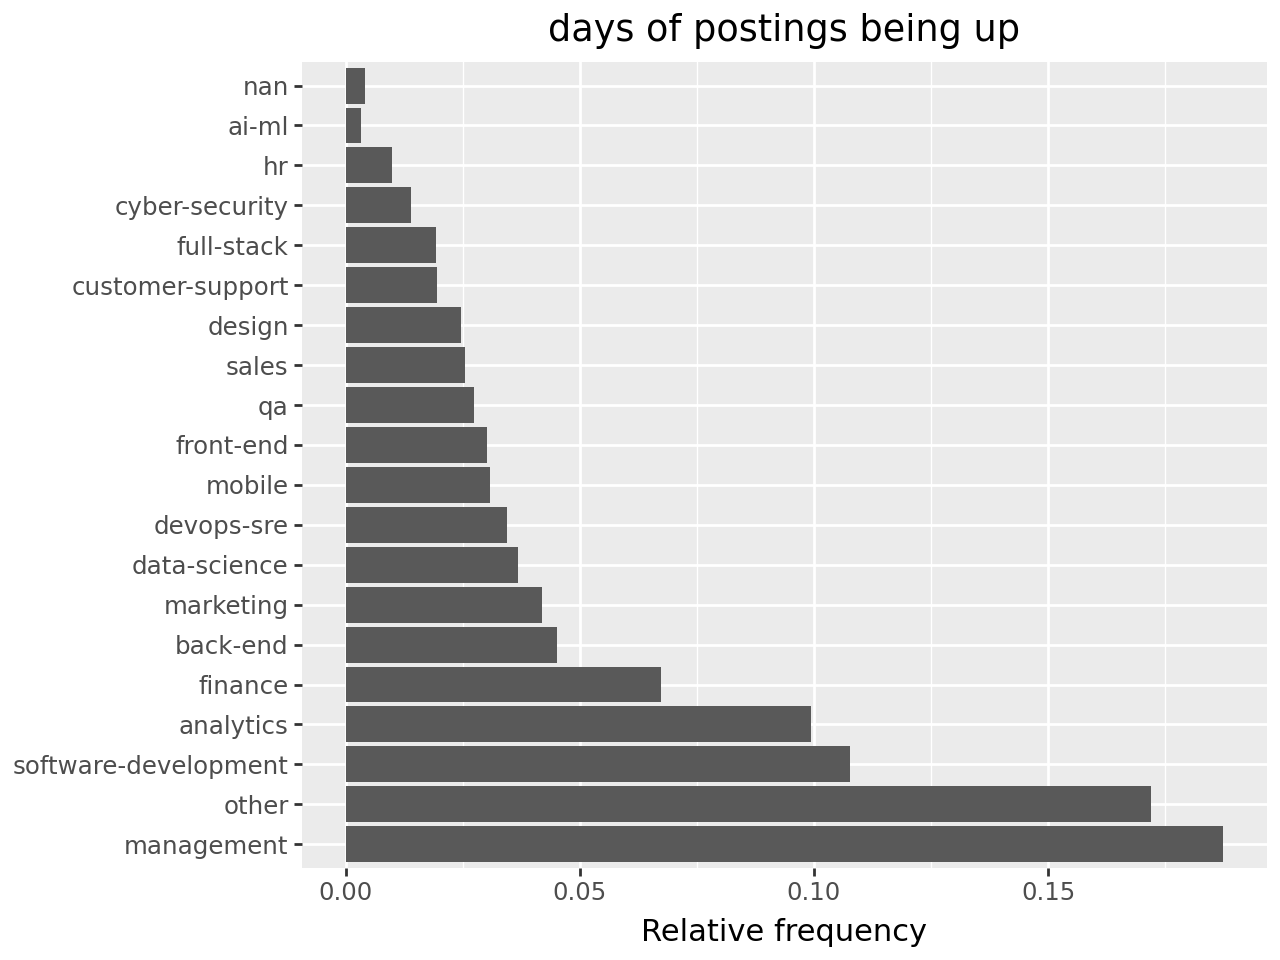

In [11]:
domains_sorted=data['domain'].value_counts().index.tolist()
domain_cat=pd.Categorical(data['domain'], categories=domains_sorted)

( p9.ggplot(
    data=data,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("days of postings being up")
)

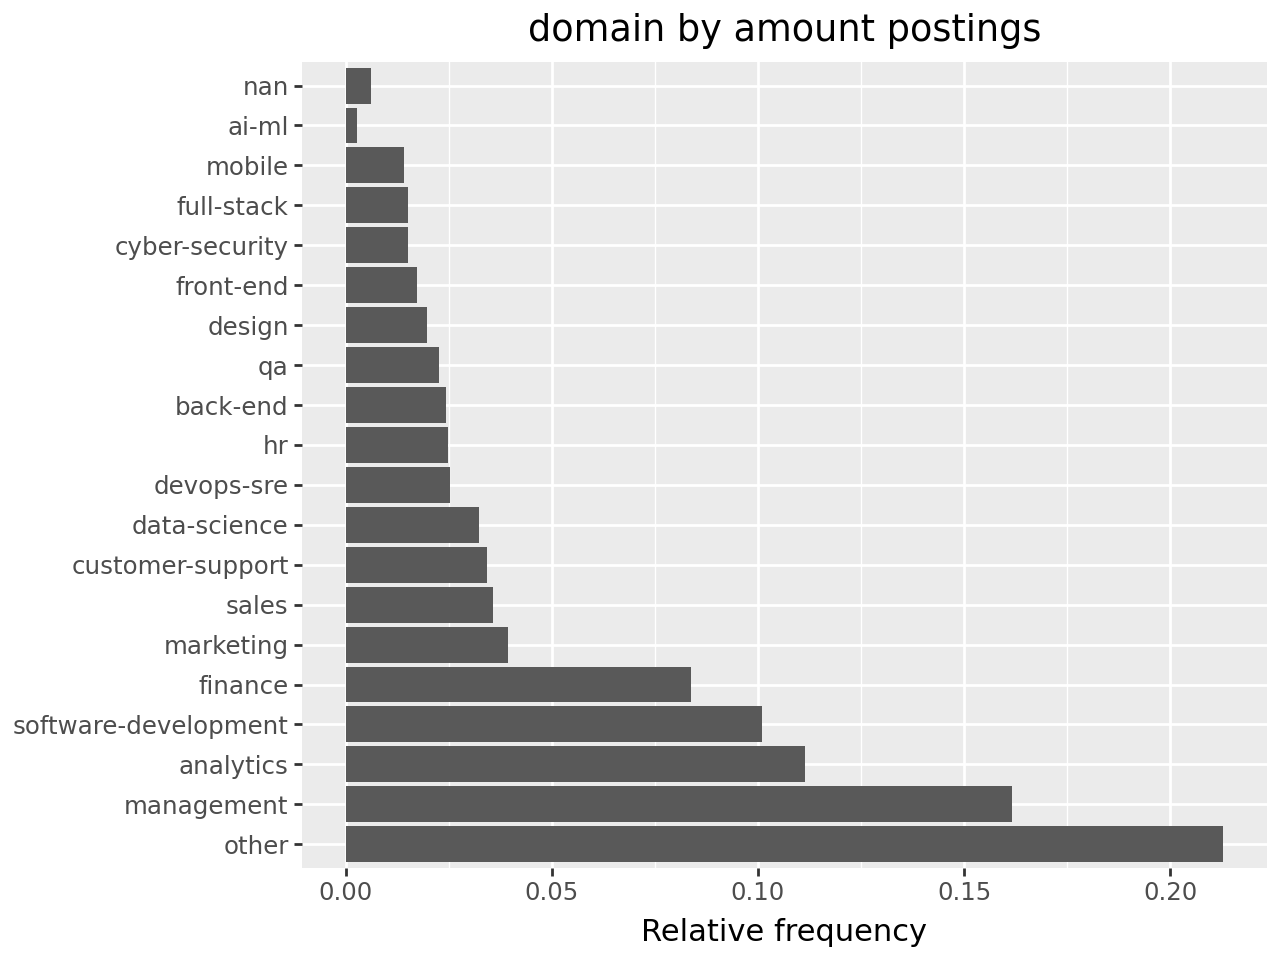

In [17]:
domains_sorted=new_data['domain'].value_counts().index.tolist()
domain_cat=pd.Categorical(new_data['domain'], categories=domains_sorted)

( p9.ggplot(
    data=new_data,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("domain by amount postings")
)

In [13]:
domain_counts_daily=data.groupby(['date_added','domain'])['domain'].count()
domain_counts_daily=domain_counts_daily.reset_index(name='counts')
domain_counts_daily


,date_added,domain,counts
0,2024-03-26,ai-ml,2
1,2024-03-26,analytics,48
2,2024-03-26,back-end,9
3,2024-03-26,customer-support,3
4,2024-03-26,cyber-security,7
...,...,...,...
4207,2024-11-10,mobile,11
4208,2024-11-10,other,53
4209,2024-11-10,qa,6
4210,2024-11-10,sales,3


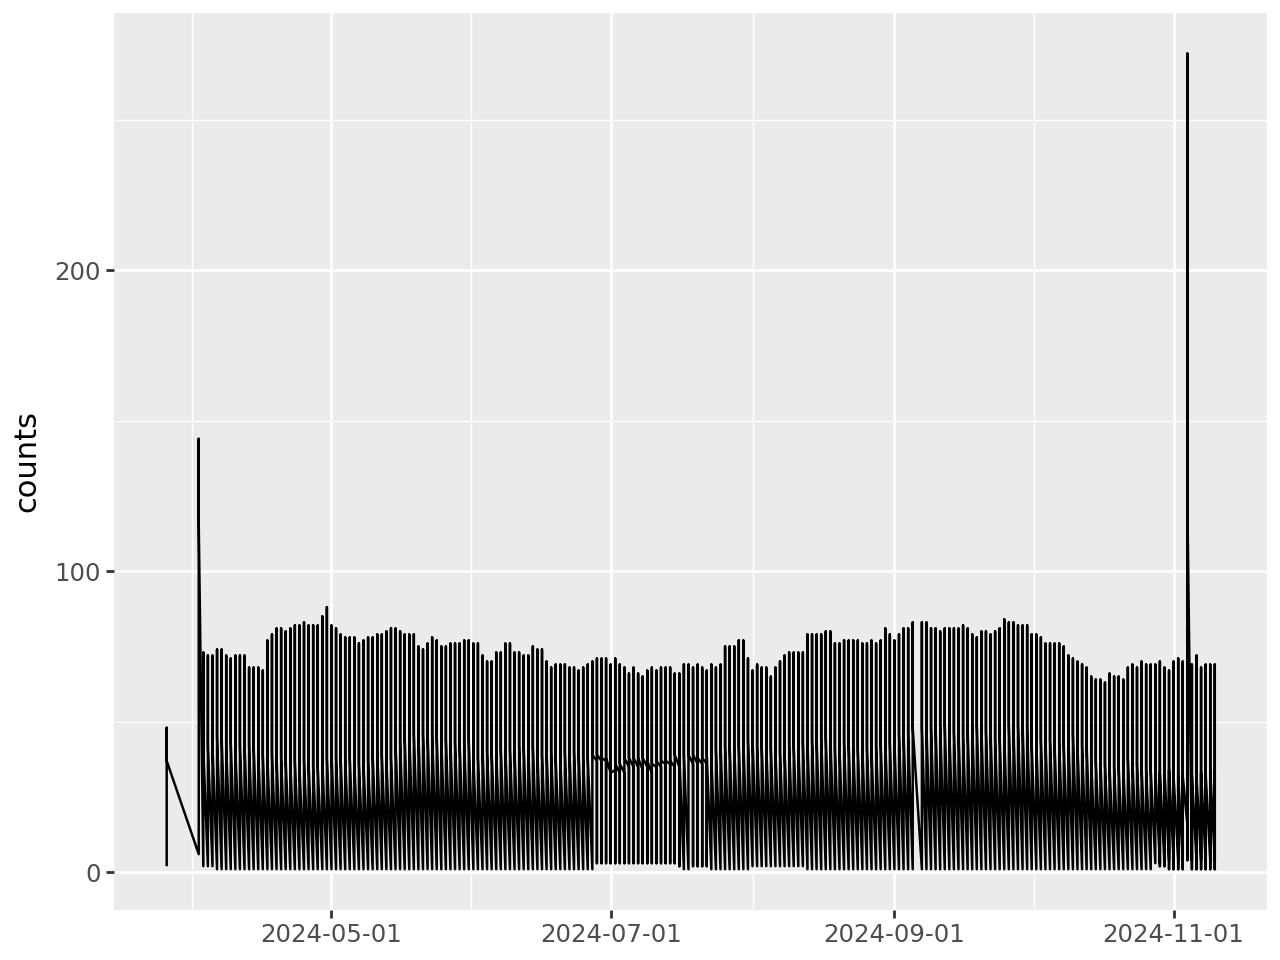

In [14]:
(p9.ggplot(
  data=domain_counts_daily,
  mapping=p9.aes(x='date_added',y='counts'))
+ p9.geom_line()
+ p9.labs(x='')#ticks by date
)

# What tech stacks are the most popular?
Sort by tech stack (if available), report frequency

# Who are the biggest hirerers?

In [15]:
new_data["company_name"].value_counts()

company_name
bolt             422
wise             304
luminor          153
seb              127
yolo group       117
                ... 
mercell            2
change invest      2
jobbatical         2
fortumo            2
boku               1
Name: count, Length: 73, dtype: int64

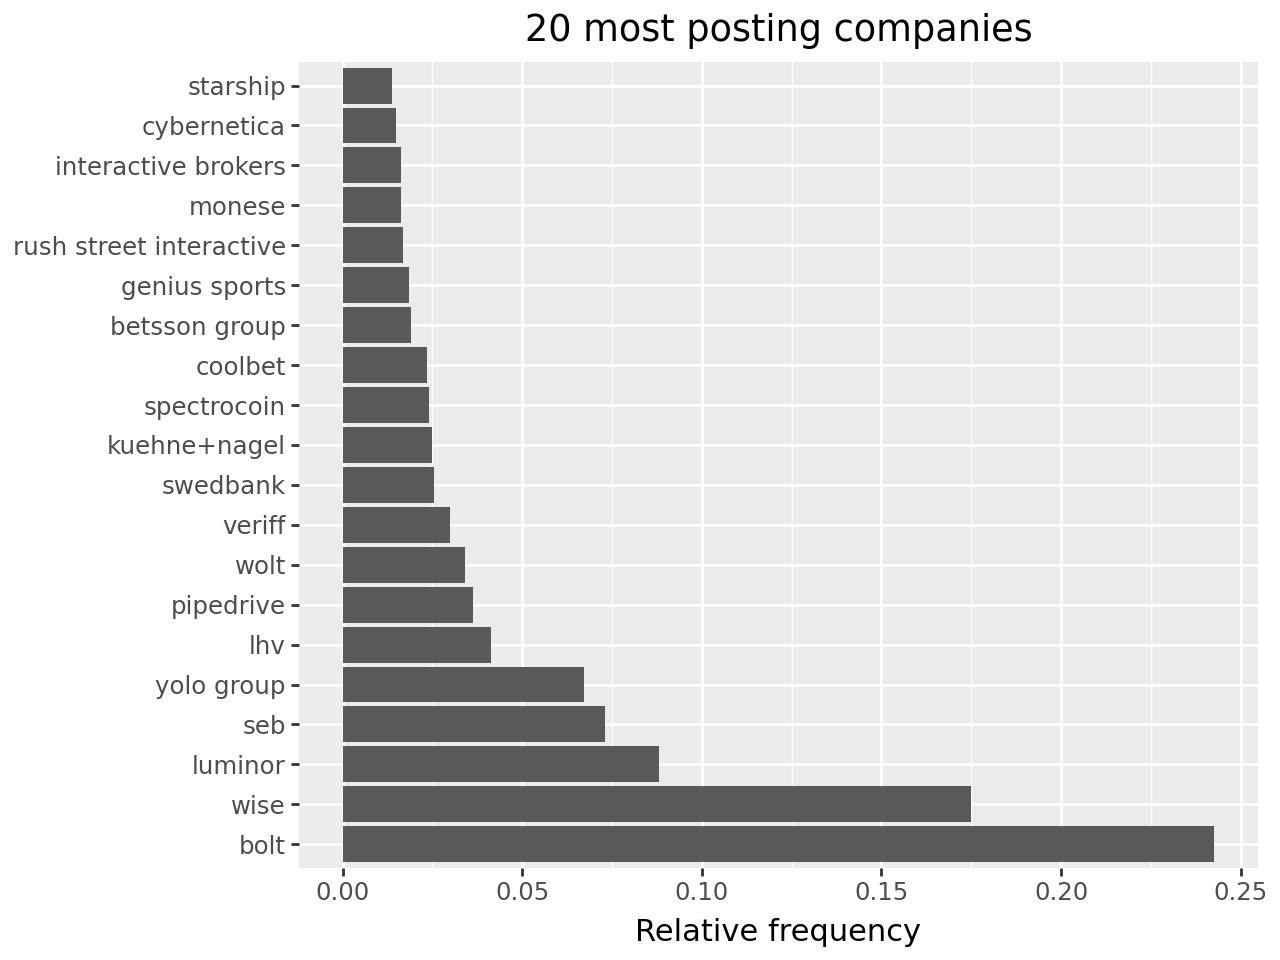

In [16]:
company_name_sorted=new_data['company_name'].value_counts().index.tolist()[:20]
new_data_top = new_data[new_data['company_name'].isin(company_name_sorted)]
domain_cat=pd.Categorical(new_data_top['company_name'], categories=company_name_sorted)

( p9.ggplot(
    data=new_data_top,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("20 most posting companies")
)


# Analisyng listings by level

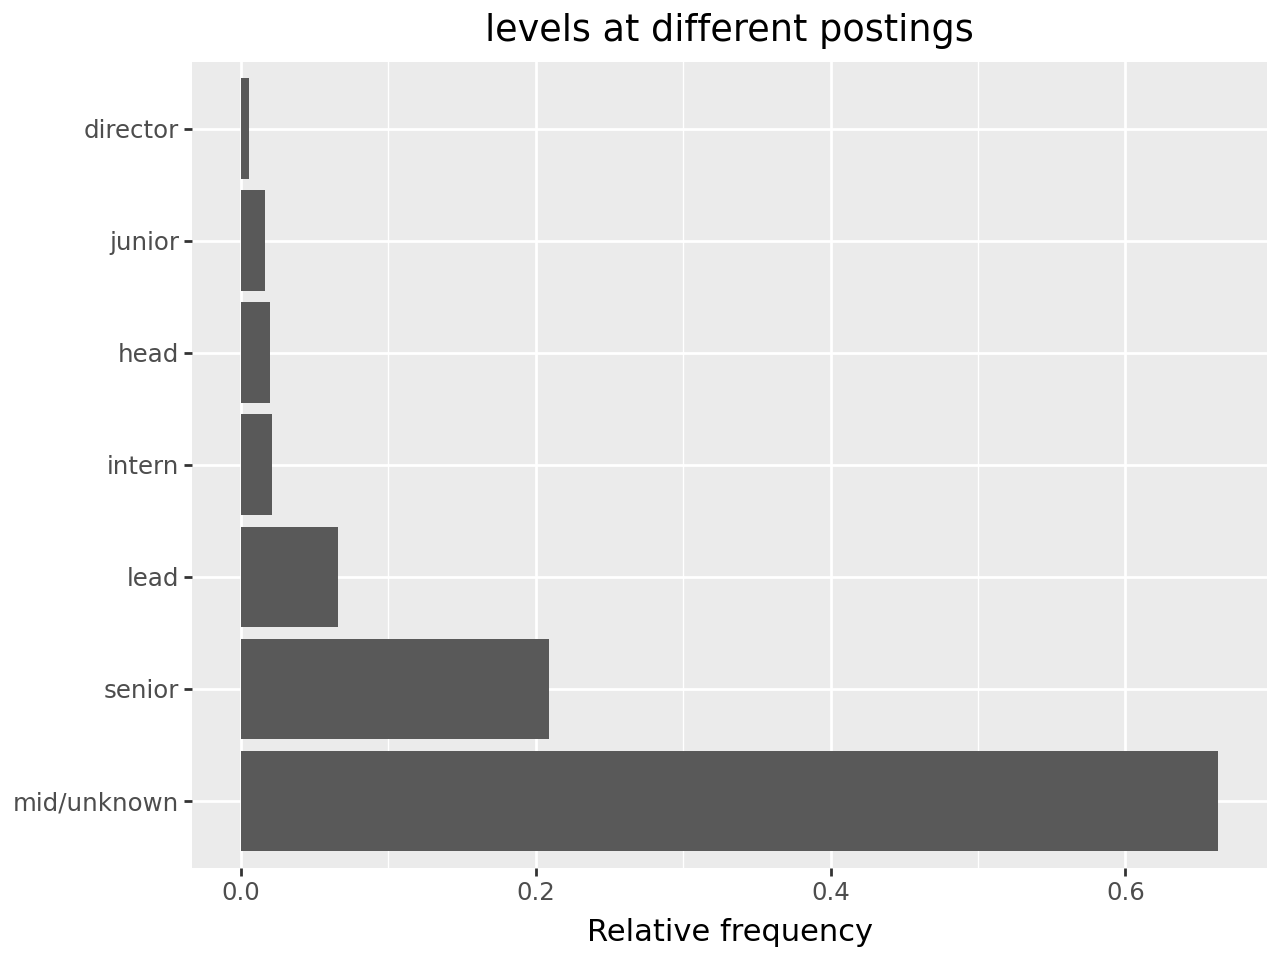

In [118]:
levels_sorted=levels_df['level'].value_counts().index.tolist()
levels_cat=pd.Categorical(levels_df['level'], categories=levels_sorted)

( p9.ggplot(
    data=new_data,
    mapping=p9.aes(x='levels_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("levels at different postings")
)